## Supervised Binary Classification with parametric Algorithm with Feature Selection

In [1]:
# Data Manipulation and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')


# Data Preparation
from sklearn.model_selection import train_test_split
import collections
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

## Import and Check Data

In [2]:
data = pd.read_csv('transform_one.csv')

In [3]:
df = data[['sensor_04',
             'sensor_12',
             'sensor_00',
             'sensor_09',
             'sensor_05',
             'sensor_06',
             'sensor_11',
             'sensor_10',
              'broken']]

In [4]:
df.head()

,sensor_04,sensor_12,sensor_00,sensor_09,sensor_05,sensor_06,sensor_11,sensor_10,broken
0,633.940975,31.498868,2.458999,15.049915,75.863615,13.366248,47.970435,37.725585,0
1,635.393490,32.547885,2.453195,15.106337,75.879854,13.360821,50.081416,39.303099,0
2,635.648140,36.587704,2.454080,15.084637,78.037966,13.353586,51.517580,42.958226,0
3,636.238420,37.281891,2.454178,15.070170,74.929848,13.341288,54.420873,45.944665,0
4,633.750000,38.934723,2.454867,15.085359,72.600750,13.342011,53.039554,41.185838,0


## Train-Test-Split, SMOTE, Scaling

In [5]:
X = df.drop('broken', axis=1)
y = df.broken

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=44)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9127, 8), (6085, 8), (9127,), (6085,))

In [7]:
# normally smote needs 6 neighbors, that is why i had to define number
sm = SMOTE(k_neighbors=2, random_state = 12)
X_trains, y_trains = sm.fit_resample(X_train, y_train)

print(y_train.value_counts())
print(collections.Counter(y_trains))

0    9123
1       4
Name: broken, dtype: int64
Counter({0: 9123, 1: 9123})


In [8]:
# Scaler Object
sc = StandardScaler()

# Fitting on train
sc.fit(X_trains)

# Transformation of train and test
X_trains = sc.transform(X_trains)
X_tests = sc.transform(X_test)

In [9]:
# Ohne Oversampling
sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

## Training and Predictions

In [10]:
lr = LogisticRegression()
lr.fit(X_trains, y_trains)

LogisticRegression()

In [11]:
y_pred = lr.predict(X_test)

In [12]:
cm = confusion_matrix(y_test, y_pred)

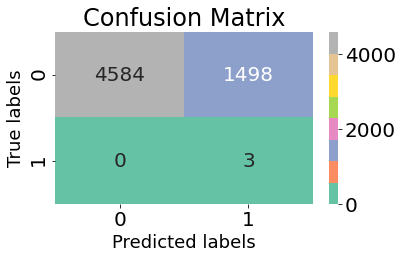

In [13]:
plt.rcParams['font.size'] = 20
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Set2', fmt="");

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=18);
ax.set_ylabel('True labels', fontsize=18); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['0', '1']); 
ax.yaxis.set_ticklabels(['0', '1']);
plt.tight_layout()

Got all of them! Still, too many false positives. Will try same procedure as before by moving threshold.

In [14]:
# Probabilities, first row probabilites of 0, second 
y_pred_ = lr.predict_proba(X_test)[:,1]

In [15]:
# make DataFrame with results of prediction
results = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'y_pred_proba':y_pred_})
results = results.sort_index()

In [16]:
results.head()

,y_test,y_pred,y_pred_proba
0,0,0,0.234106
1,0,0,0.487120
3,0,1,0.944525
6,0,1,0.920055
11,0,1,0.871741


In [17]:
# Where did prediction go wrong with default threshold?
results[(y_test == 0) & (y_pred == 1)].sort_values('y_pred_proba', ascending=True).head(20)

,y_test,y_pred,y_pred_proba
5181,0,1,0.500004
3175,0,1,0.500299
13357,0,1,0.501434
3747,0,1,0.502135
6589,0,1,0.502738
379,0,1,0.503254
6302,0,1,0.503594
524,0,1,0.503804
3272,0,1,0.504496
600,0,1,0.505393


There are many false positives in the prediction. Looking at the Data it can be seen, that the Algorithm was not too sure about many of them. So it could be  a valuable try to move the threshold that detemines, which Datapoint is considered to be a positive, in this case, a pump failure. 

In [18]:
# Create new assignment of target variable
th7 = np.where(results['y_pred_proba']>=0.7,1,0)
th8 = np.where(results['y_pred_proba']>=0.8,1,0)
th9 = np.where(results['y_pred_proba']>=0.9,1,0)

In [19]:
# Add new columns with new thresholds to Results
results.insert(2, "thresh_7", th7, True)
results.insert(3, "thresh_8", th8, True)
results.insert(4, "thresh_9", th9, True)

In [20]:
# Check new DataFrame
results.head()

,y_test,y_pred,thresh_7,thresh_8,thresh_9,y_pred_proba
0,0,0,0,0,0,0.234106
1,0,0,0,0,0,0.487120
3,0,1,1,1,1,0.944525
6,0,1,1,1,1,0.920055
11,0,1,1,1,0,0.871741


In [21]:
# Look at new Confusion Matrices
cm7 = confusion_matrix(results.y_test, results.thresh_7)
cm7

array([[4905, 1177],
       [   0,    3]], dtype=int64)

In [22]:
cm8 = confusion_matrix(results.y_test, results.thresh_8)
cm8

array([[5078, 1004],
       [   0,    3]], dtype=int64)

In [23]:
cm9 = confusion_matrix(results.y_test, results.thresh_9)
cm9

array([[5307,  775],
       [   0,    3]], dtype=int64)

## Conclusion
- We predicted 3 out of 3 pump failures of the test set! There are still too many false flags
- Moving the threshold upwards can reduce these. 

## Future Work
- Look at false negative value and find out, why LR did not catch it
- Try more complex Algorithms
- Try Feature Engineering: PCA
- Hyperparameter Tuning: Regulation